In [1]:
import time
import hydroeval as he
import json
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import xarray as xr
import sys
from datetime import date
from datetime import datetime, timedelta
from sklearn.linear_model import LinearRegression
from scipy.stats import sem
from sklearn.metrics import mean_squared_error
import math
from scipy import stats
import statistics
import os

In [2]:
#make plots appear clean
mpl.rcParams['font.size'] = 12
mpl.rcParams['legend.fontsize'] = 'medium'
mpl.rcParams['figure.titlesize'] = 'medium'
mpl.rcParams['lines.linewidth'] = 2.0 

### **PMP ASSESSMENT**

In [3]:
## Load Dataset
df = pd.read_csv('./DataFolder/pmp_data.csv')
# print(df)

In [4]:
## Pass dataset to array
xdf = df.to_xarray()

## HERSHFIELD Station PMP (Annual Max)
ST30m = xdf['obs30m']; ST1h = xdf['obs1h']; ST2h = xdf['obs2h']; 
ST3h = xdf['obs3h']; ST6h = xdf['obs6h']; ST12h = xdf['obs12h']; 
ST24h = xdf['obs24h']; ST48h = xdf['obs48h']; ST72h = xdf['obs72h'];

## HERSHFIELD IMERG PMP (Annual Max)
IM30m = xdf['pre30m']; IM1h = xdf['pre1h']; IM2h = xdf['pre2h']; 
IM3h = xdf['pre3h']; IM6h = xdf['pre6h']; IM12h = xdf['pre12h']; 
IM24h = xdf['pre24h']; IM48h = xdf['pre48h']; IM72h = xdf['pre72h'];

## HERSHFIELD IMERG PMP (Partial Duration)
IMP30m = xdf['ppre30m']; IMP1h = xdf['ppre1h']; IMP2h = xdf['ppre2h']; 
IMP3h = xdf['ppre3h']; IMP6h = xdf['ppre6h']; IMP12h = xdf['ppre12h']; 
IMP24h = xdf['ppre24h']; IMP48h = xdf['ppre48h']; IMP72h = xdf['ppre72h'];

## MODIFIED IMERG PMP (Partial Duration)
mP30m = xdf['mpre30m']; mP1h = xdf['mpre1h']; mP2h = xdf['mpre2h']; 
mP3h = xdf['mpre3h']; mP6h = xdf['mpre6h']; mP12h = xdf['mpre12h']; 
mP24h = xdf['mpre24h']; mP48h = xdf['mpre48h']; mP72h = xdf['mpre72h'];

#### **Statistics (HERSHFIELD Station PMP vs HERSHFIELD IMERG PMP) - Based on Annual Maximum**

In [24]:
# Read input data
obs_list = [ST30m, ST1h, ST2h, ST3h, ST6h, ST12h, ST24h, ST48h, ST72h]                     # HERSHFIELD Station PMP (Annual Max)
pre_list = [IM30m, IM1h, IM2h, IM3h, IM6h, IM12h, IM24h, IM48h, IM72h]                     # HERSHFIELD IMERG PMP (Annual Max)

titles = ['30-min', '1-hr', '2-hr', '3-hr', '6-hr', '12-hr', '24-hr', '48-hr', '72-hr']
durations = [0.5, 1, 2, 3, 6, 12, 24, 48, 72]

# Create output directory if it does not exist
output_dir = "Stat_folder"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

results = []

# Extended Evaluation Function
def STATS(obs, pred):
    # Remove NaNs to avoid invalid calculations
    mask = np.isfinite(obs) & np.isfinite(pred)
    obs = obs[mask]
    pred = pred[mask]

    # Correlation coefficient
    r_cor, _ = stats.pearsonr(obs, pred)
    r_cor_val = np.round(r_cor, 3)

    # Relative Bias (RB%)
    RB1 = np.sum(pred - obs) / np.sum(obs) * 100
    RB = np.round(RB1, 3)

    # RMSE
    rmse = np.sqrt(np.mean((pred - obs) ** 2))
    rmse_val = np.round(rmse, 5)

    # Mean Bias Ratio (MBR)
    mbr = np.mean(pred) / np.mean(obs)
    mbr = np.clip(mbr, 0, 1)
    mbr_val = np.round(mbr, 4)

    # Nash–Sutcliffe Efficiency (NSE)
    nse = he.evaluator(he.nse, pred, obs)[0]
    nse_val = np.round(nse, 4)

    # Kling–Gupta Efficiency (KGE)
    kge, _, _, _ = he.evaluator(he.kge, pred, obs)
    kge_val = np.round(kge[0], 4)

    # print("------------Start--------------")
    # print(f"r Cor  : {r_cor_val}")
    # print(f"R Bias : {RB}")
    # print(f"RMSE   : {rmse_val}")
    # print(f"MBR    : {mbr_val}")
    # print(f"NSE    : {nse_val}")
    # print(f"KGE    : {kge_val}")
    # print("----------- END---------------\n")

    return r_cor_val, RB, rmse_val, mbr_val, nse_val, kge_val


# Loop through datasets and collect results
for obs, pred, label, duration in zip(obs_list, pre_list, titles, durations):
    # print(f"{label}:")
    r, rb, rmse, mbr, nse, kge = STATS(obs.values, pred.values)
    nrmse = np.round(rmse / duration, 5)
    results.append([label, duration, r, rb, rmse, nrmse, mbr, nse, kge])

# Save results to CSV
df_out = pd.DataFrame(results, columns=['Label', 'Duration (hr)', 'r', 'RB%', 'RMSE (mm)', 'NRMSE', 'MBR', 'NSE', 'KGE'])
output_path = os.path.join(output_dir, '1_pmp_stat_hershfield_stn_vs_img.csv')
df_out.to_csv(output_path, index=False)

print(f"Calculation completed and saved to {output_path}")


Calculation completed and saved to Stat_folder\1_pmp_stat_hershfield_stn_vs_img.csv


#### **Statistics (HERSHFIELD IMERG PMP vs Modified IMERG PMP) - Based on Partial Duration**

In [25]:
# Read input data
obs_list = [IMP30m, IMP1h, IMP2h, IMP3h, IMP6h, IMP12h, IMP24h, IMP48h, IMP72h]            # HERSHFIELD IMERG PMP (Partial Duration)
pre_list = [mP30m, mP1h, mP2h, mP3h, mP6h, mP12h, mP24h, mP48h, mP72h]                     # MODIFIED IMERG PMP (Partial Duration)

titles = ['30-min', '1-hr', '2-hr', '3-hr', '6-hr', '12-hr', '24-hr', '48-hr', '72-hr']
durations = [0.5, 1, 2, 3, 6, 12, 24, 48, 72]

# Create output directory if it does not exist
output_dir = "Stat_folder"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

results = []

# Extended Evaluation Function
def STATS(obs, pred):
    # Remove NaNs to avoid invalid calculations
    mask = np.isfinite(obs) & np.isfinite(pred)
    obs = obs[mask]
    pred = pred[mask]

    # Correlation coefficient
    r_cor, _ = stats.pearsonr(obs, pred)
    r_cor_val = np.round(r_cor, 3)

    # Relative Bias (RB%)
    RB1 = np.sum(pred - obs) / np.sum(obs) * 100
    RB = np.round(RB1, 3)

    # RMSE
    rmse = np.sqrt(np.mean((pred - obs) ** 2))
    rmse_val = np.round(rmse, 5)

    # Mean Bias Ratio (MBR)
    mbr = np.mean(pred) / np.mean(obs)
    mbr = np.clip(mbr, 0, 1)
    mbr_val = np.round(mbr, 4)

    # Nash–Sutcliffe Efficiency (NSE)
    nse = he.evaluator(he.nse, pred, obs)[0]
    nse_val = np.round(nse, 4)

    # Kling–Gupta Efficiency (KGE)
    kge, _, _, _ = he.evaluator(he.kge, pred, obs)
    kge_val = np.round(kge[0], 4)

    # print("------------Start--------------")
    # print(f"r Cor  : {r_cor_val}")
    # print(f"R Bias : {RB}")
    # print(f"RMSE   : {rmse_val}")
    # print(f"MBR    : {mbr_val}")
    # print(f"NSE    : {nse_val}")
    # print(f"KGE    : {kge_val}")
    # print("----------- END---------------\n")

    return r_cor_val, RB, rmse_val, mbr_val, nse_val, kge_val


# Loop through datasets and collect results
for obs, pred, label, duration in zip(obs_list, pre_list, titles, durations):
    # print(f"{label}:")
    r, rb, rmse, mbr, nse, kge = STATS(obs.values, pred.values)
    nrmse = np.round(rmse / duration, 5)
    results.append([label, duration, r, rb, rmse, nrmse, mbr, nse, kge])

# Save results to CSV
df_out = pd.DataFrame(results, columns=['Label', 'Duration (hr)', 'r', 'RB%', 'RMSE (mm)', 'NRMSE', 'MBR', 'NSE', 'KGE'])
output_path = os.path.join(output_dir, '2_pmp_stat_hershfield_img_vs_modified_img.csv')
df_out.to_csv(output_path, index=False)

print(f"Calculation completed and saved to {output_path}")


Calculation completed and saved to Stat_folder\2_pmp_stat_hershfield_img_vs_modified_img.csv


#### **Plots (HERSHFIELD Station PMP vs HERSHFIELD IMERG PMP) - Based on Annual Maximum**

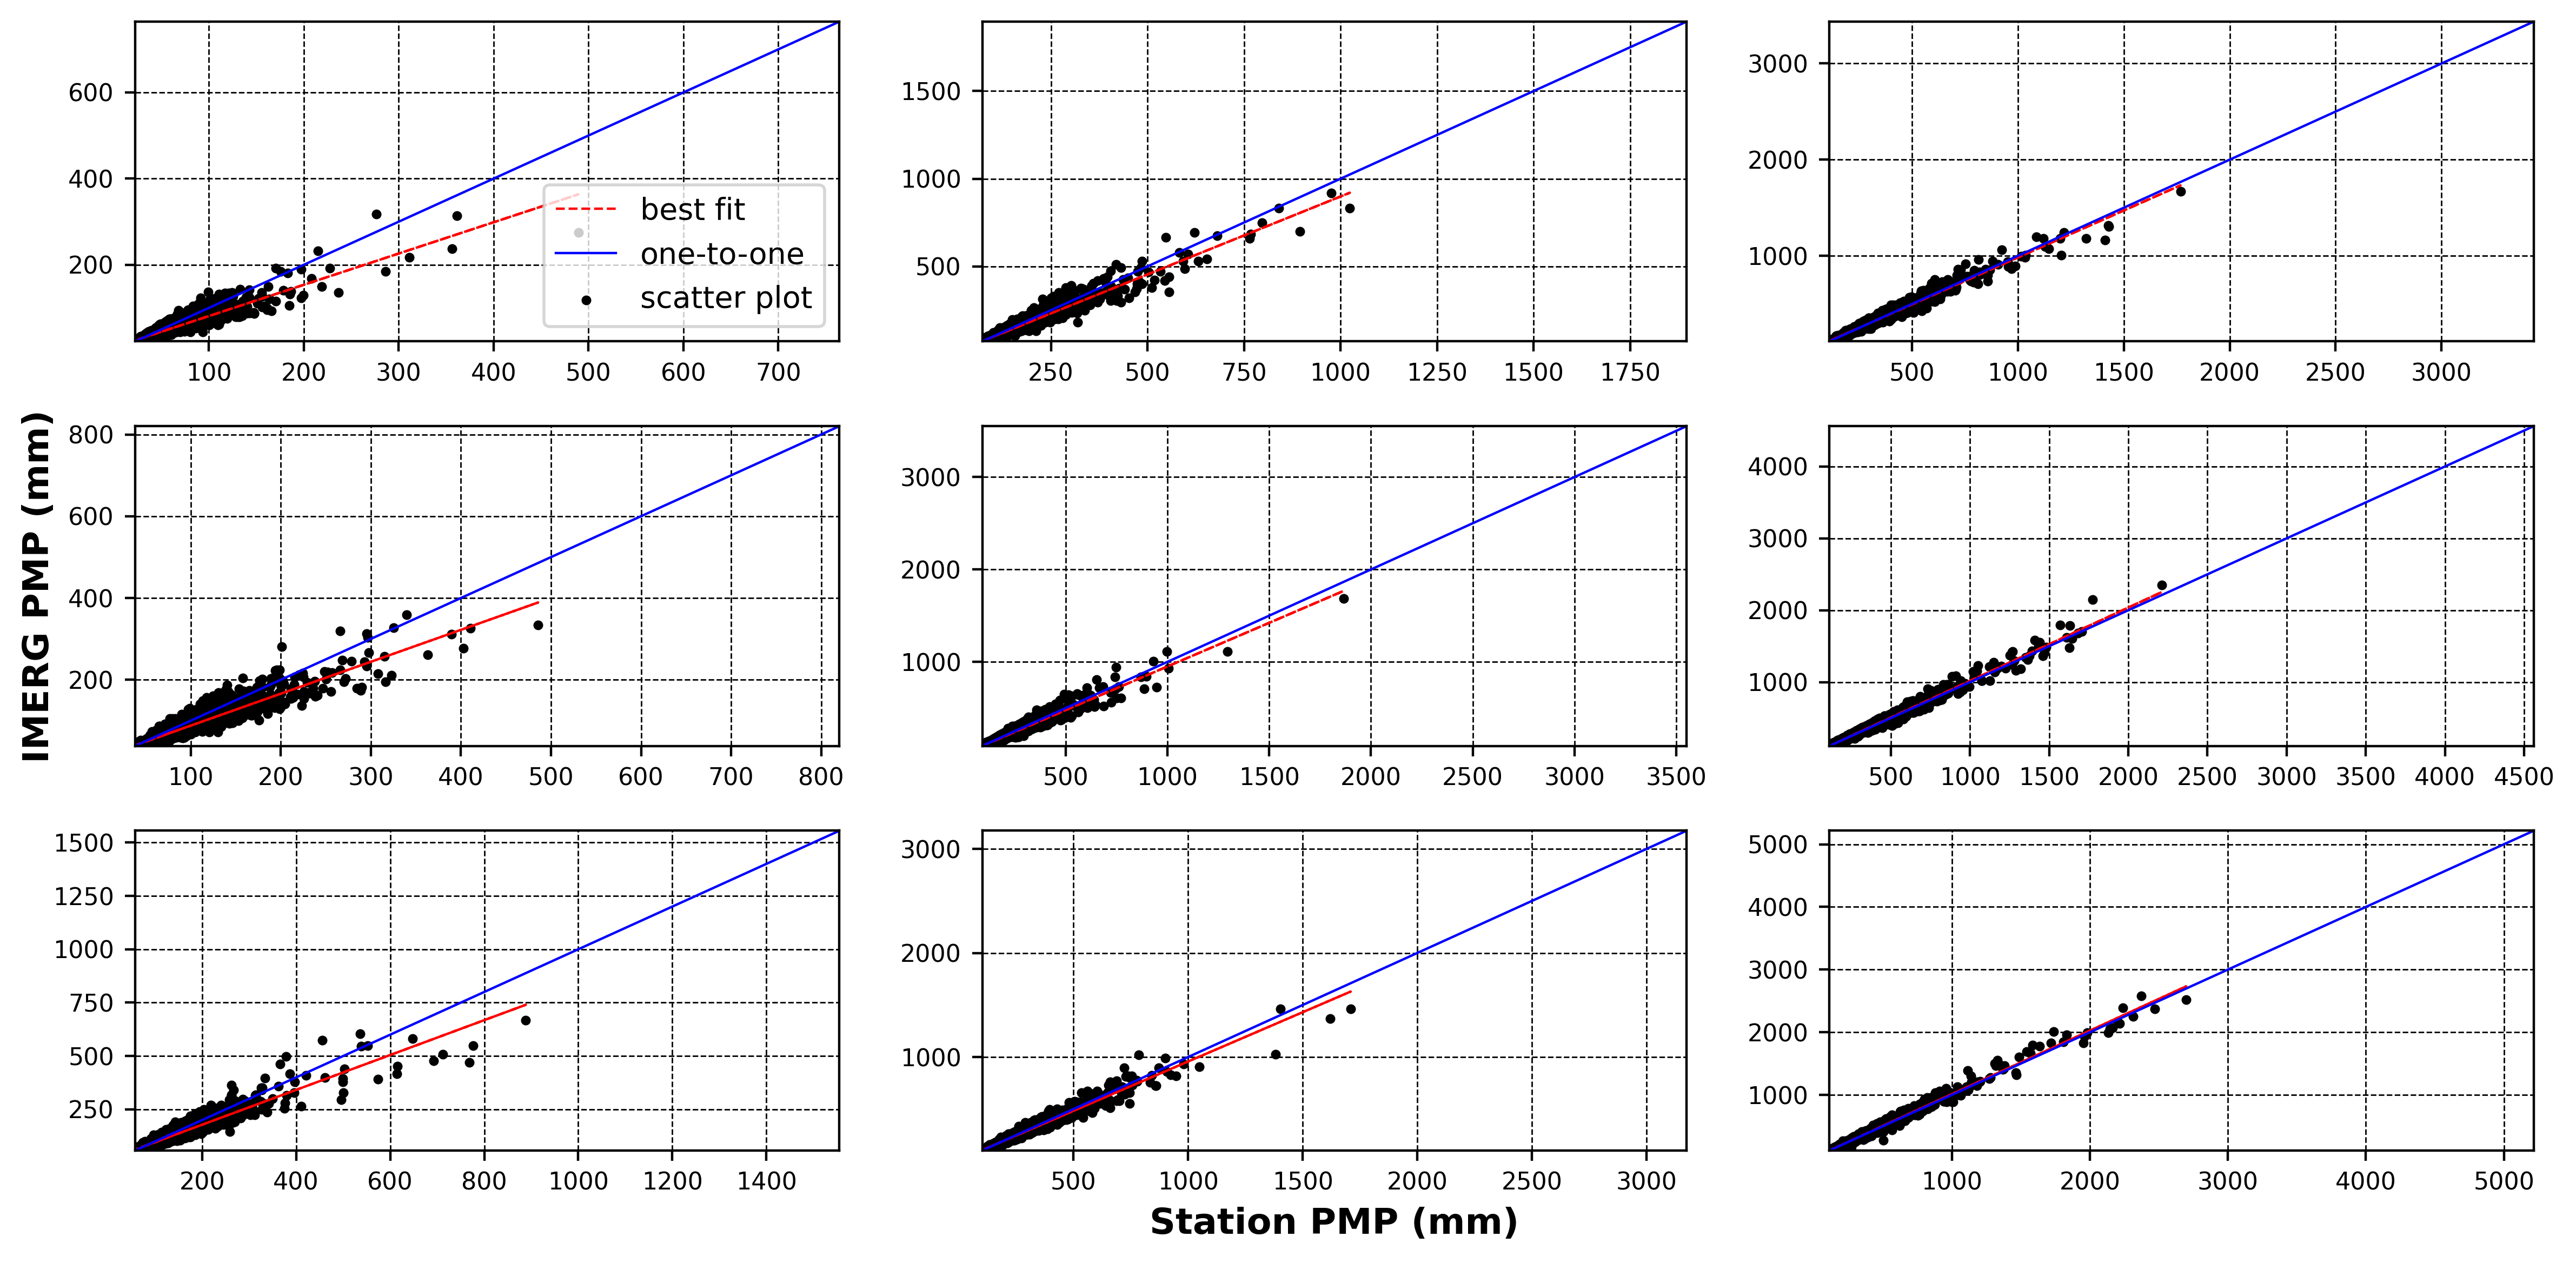

In [20]:
## Station pmp
ST30m = xdf['obs30m']; ST1h = xdf['obs1h']; ST2h = xdf['obs2h']; 
ST3h = xdf['obs3h']; ST6h = xdf['obs6h']; ST12h = xdf['obs12h']; 
ST24h = xdf['obs24h']; ST48h = xdf['obs48h']; ST72h = xdf['obs72h'];

## Annual Max pmp
IM30m = xdf['pre30m']; IM1h = xdf['pre1h']; IM2h = xdf['pre2h']; 
IM3h = xdf['pre3h']; IM6h = xdf['pre6h']; IM12h = xdf['pre12h']; 
IM24h = xdf['pre24h']; IM48h = xdf['pre48h']; IM72h = xdf['pre72h'];

yylabel = 'IMERG PMP (mm)' # IMERG
xxlabel = 'Station PMP (mm)' # NOAA

# Plot each output column against the unique "Year" values
plt.figure(figsize=(12, 6), dpi=400) 

# 30-min Assessment
plt.subplot(3,3,1) #projection='3d'
plt.scatter(ST30m, IM30m, c="black", marker='o', s=5, label = "scatter plot")
a1, b1 = np.polyfit(ST30m, IM30m, 1)
plt.plot(ST30m, a1*ST30m+b1, color='red', linestyle='--', linewidth=0.8, label = "best fit") 
plt.plot([min(ST30m + IM30m), max(ST30m + IM30m)], [min(ST30m + IM30m), max(ST30m + IM30m)], color='blue', linestyle='-', linewidth=0.8, label = "one-to-one")
# plt.ylabel(yylabel, fontweight='bold', fontsize=12)
plt.legend(loc=4, fontsize=10)
plt.tick_params(axis='both', which='major', labelsize=8)
plt.grid(True, linestyle='--', linewidth='0.5', color='black', axis='both')
plt.xlim(min(ST30m + IM30m), max(ST30m + IM30m))
plt.ylim(min(ST30m + IM30m), max(ST30m + IM30m))

# 1-hr Assessment
plt.subplot(3,3,4) #projection='3d'
plt.scatter(ST1h, IM1h, c="black", marker='o', s=5, label = "Scatter Plot")
a2, b2 = np.polyfit(ST1h, IM1h, 1)
plt.plot(ST1h, a2*ST1h+b2, color='red', linestyle='--', linewidth=0.8, label = "Best fit line") 
plt.plot([min(ST1h + IM1h), max(ST1h + IM1h)], [min(ST1h + IM1h), max(ST1h + IM1h)], color='blue', linestyle='-', linewidth=0.8, label = "one-to-one line")
plt.ylabel(yylabel, fontweight='bold', fontsize=12)
plt.tick_params(axis='both', which='major', labelsize=8)
plt.grid(True, linestyle='--', linewidth='0.5', color='black', axis='both')
plt.xlim(min(ST1h + IM1h), max(ST1h + IM1h))
plt.ylim(min(ST1h + IM1h), max(ST1h + IM1h))

# 2-hr Assessment
plt.subplot(3,3,7) #projection='3d'
plt.scatter(ST2h, IM2h, c="black", marker='o', s=5, label = "Scatter Plot")
a3, b3 = np.polyfit(ST2h, IM2h, 1)
plt.plot(ST2h, a3*ST2h+b3, color='red', linestyle='--', linewidth=0.8, label = "Best fit line") 
plt.plot([min(ST2h + IM2h), max(ST2h + IM2h)], [min(ST2h + IM2h), max(ST2h + IM2h)], color='blue', linestyle='-', linewidth=0.8, label = "one-to-one line")
# plt.xlabel(xxlabel, fontweight='bold', fontsize=12)
# plt.ylabel(yylabel, fontweight='bold', fontsize=12)
plt.tick_params(axis='both', which='major', labelsize=8)
plt.grid(True, linestyle='--', linewidth='0.5', color='black', axis='both')
plt.xlim(min(ST2h + IM2h), max(ST2h + IM2h))
plt.ylim(min(ST2h + IM2h), max(ST2h + IM2h))

# 3-hr Assessment
plt.subplot(3,3,2) #projection='3d'
plt.scatter(ST3h, IM3h, c="black", marker='o', s=5, label = "Scatter Plot")
a4, b4 = np.polyfit(ST3h, IM3h, 1)
plt.plot(ST3h, a4*ST3h+b4, color='red', linestyle='--', linewidth=0.8, label = "Best fit line") 
plt.plot([min(ST3h + IM3h), max(ST3h + IM3h)], [min(ST3h + IM3h), max(ST3h + IM3h)], color='blue', linestyle='-', linewidth=0.8, label = "one-to-one line")
plt.tick_params(axis='both', which='major', labelsize=8)
plt.grid(True, linestyle='--', linewidth='0.5', color='black', axis='both')
plt.xlim(min(ST3h + IM3h), max(ST3h + IM3h))
plt.ylim(min(ST3h + IM3h), max(ST3h + IM3h))

# 6-hr Assessment
plt.subplot(3,3,5) #projection='3d'
plt.scatter(ST6h, IM6h, c="black", marker='o', s=5, label = "Scatter Plot")
a5, b5 = np.polyfit(ST6h, IM6h, 1)
plt.plot(ST6h, a5*ST6h+b5, color='red', linestyle='--', linewidth=0.8, label = "Best fit line") 
plt.plot([min(ST6h + IM6h), max(ST6h + IM6h)], [min(ST6h + IM6h), max(ST6h + IM6h)], color='blue', linestyle='-', linewidth=0.8, label = "one-to-one line")
plt.tick_params(axis='both', which='major', labelsize=8)
plt.grid(True, linestyle='--', linewidth='0.5', color='black', axis='both')
plt.xlim(min(ST6h + IM6h), max(ST6h + IM6h))
plt.ylim(min(ST6h + IM6h), max(ST6h + IM6h))

# 12-hr Assessment
plt.subplot(3,3,8) #projection='3d'
plt.scatter(ST12h, IM12h, c="black", marker='o', s=5, label = "Scatter Plot")
a6, b6 = np.polyfit(ST12h, IM12h, 1)
plt.plot(ST12h, a6*ST12h+b6, color='red', linestyle='--', linewidth=0.8, label = "Best fit line") 
plt.plot([min(ST12h + IM12h), max(ST12h + IM12h)], [min(ST12h + IM12h), max(ST12h + IM12h)], color='blue', linestyle='-', linewidth=0.8, label = "one-to-one line")
plt.xlabel(xxlabel, fontweight='bold', fontsize=12)
plt.tick_params(axis='both', which='major', labelsize=8)
plt.grid(True, linestyle='--', linewidth='0.5', color='black', axis='both')
plt.xlim(min(ST12h + IM12h), max(ST12h + IM12h))
plt.ylim(min(ST12h + IM12h), max(ST12h + IM12h))

# 24-hr Assessment
plt.subplot(3,3,3) #projection='3d'
a7, b7 = np.polyfit(ST24h, IM24h, 1)
plt.plot(ST24h, a7*ST24h+b7, color='red', linestyle='--', linewidth=0.8, label = "Best fit line") 
plt.scatter(ST24h, IM24h, c="black", marker='o', s=5, label = "Scatter Plot")
plt.plot([min(ST24h + IM24h), max(ST24h + IM24h)], [min(ST24h + IM24h), max(ST24h + IM24h)], color='blue', linestyle='-', linewidth=0.8, label = "one-to-one line")
plt.tick_params(axis='both', which='major', labelsize=8)
plt.grid(True, linestyle='--', linewidth='0.5', color='black', axis='both')
plt.xlim(min(ST24h + IM24h), max(ST24h + IM24h))
plt.ylim(min(ST24h + IM24h), max(ST24h + IM24h))

# 2-day Assessment
plt.subplot(3,3,6) #projection='3d'
a8, b8 = np.polyfit(ST48h, IM48h, 1)
plt.plot(ST48h, a8*ST48h+b8, color='red', linestyle='--', linewidth=0.8, label = "Best fit line") 
plt.scatter(ST48h, IM48h, c="black", marker='o', s=5, label = "Scatter Plot")
plt.plot([min(ST48h + IM48h), max(ST48h + IM48h)], [min(ST48h + IM48h), max(ST48h + IM48h)], color='blue', linestyle='-', linewidth=0.8, label = "one-to-one line")
plt.tick_params(axis='both', which='major', labelsize=8)
plt.grid(True, linestyle='--', linewidth='0.5', color='black', axis='both')
plt.xlim(min(ST48h + IM48h), max(ST48h + IM48h))
plt.ylim(min(ST48h + IM48h), max(ST48h + IM48h))

# 3-day Assessment
plt.subplot(3,3,9) #projection='3d'
a9, b9 = np.polyfit(ST72h, IM72h, 1)
plt.plot(ST72h, a9*ST72h+b9, color='red', linestyle='--', linewidth=0.8, label = "Best fit line") 
plt.scatter(ST72h, IM72h, c="black", marker='o', s=5, label = "Scatter Plot")
plt.plot([min(ST72h + IM72h), max(ST72h + IM72h)], [min(ST72h + IM72h), max(ST72h + IM72h)], color='blue', linestyle='-', linewidth=0.8, label = "one-to-one line")
# plt.xlabel(xxlabel, fontweight='bold', fontsize=12)
plt.tick_params(axis='both', which='major', labelsize=8)
plt.grid(True, linestyle='--', linewidth='0.5', color='black', axis='both')
plt.xlim(min(ST72h + IM72h), max(ST72h + IM72h))
plt.ylim(min(ST72h + IM72h), max(ST72h + IM72h))

# plt.suptitle('Station PMP versus Annual-max PMP', fontweight='bold', fontsize=20)

plt.tight_layout()
plt.savefig("Plots/z1_pmp_hershfield_station_vs_imerg.png")
plt.show()

#### **Plots (HERSHFIELD IMERG PMP vs Modified IMERG PMP) - Based on Partial Duration**

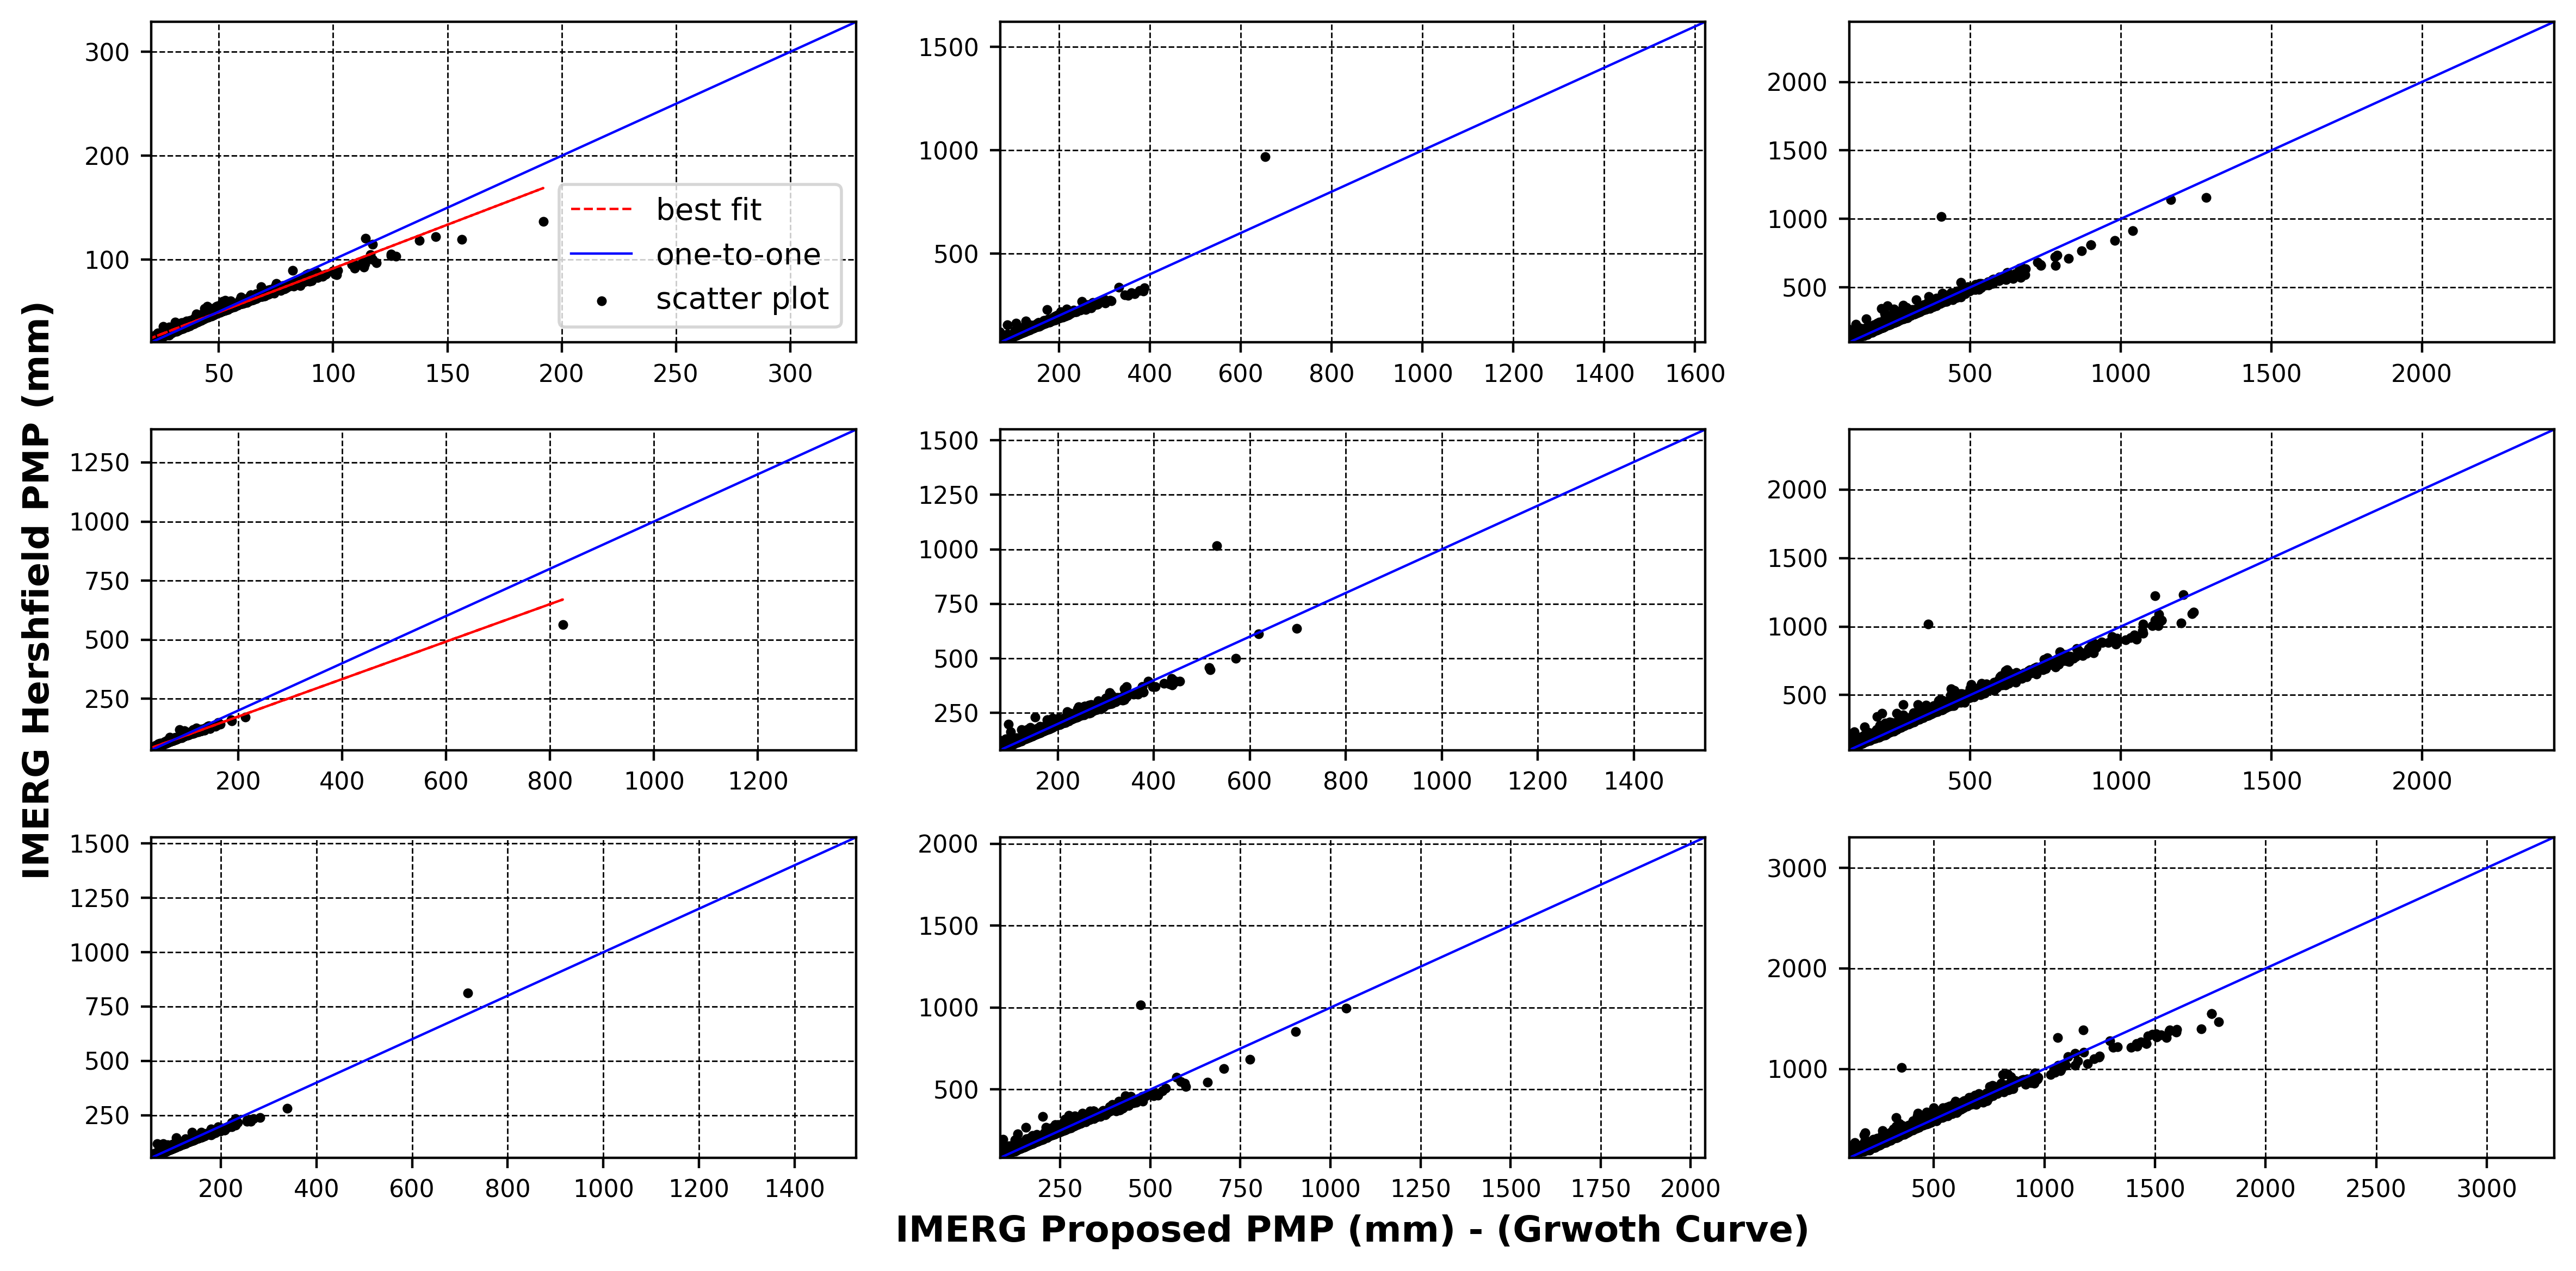

In [5]:
## HERSHFIELD IMERG PMP (Partial Duration)
ST30m = IMP30m; ST1h = IMP1h; ST2h = IMP2h; 
ST3h = IMP3h; ST6h = IMP6h; ST12h = IMP12h;
ST24h = IMP24h; ST48h = IMP48h; ST72h = IMP72h;

## MODIFIED IMERG PMP (Partial Duration)
IM30m = mP30m; IM1h = mP1h; IM2h = mP2h; 
IM3h = mP3h; IM6h = mP6h; IM12h = mP12h; 
IM24h = mP24h; IM48h = mP48h; IM72h = mP72h;

yylabel = 'IMERG Hershfield PMP (mm)'  # Hershfield
xxlabel = 'IMERG Proposed PMP (mm) - (Grwoth Curve)'    # Modified

# Plot each output column against the unique "Year" values
plt.figure(figsize=(12, 6), dpi=400) 

# 30-min Assessment
plt.subplot(3,3,1) #projection='3d'
plt.scatter(ST30m, IM30m, c="black", marker='o', s=5, label = "scatter plot")
a1, b1 = np.polyfit(ST30m, IM30m, 1)
plt.plot(ST30m, a1*ST30m+b1, color='red', linestyle='--', linewidth=0.8, label = "best fit") 
plt.plot([min(ST30m + IM30m), max(ST30m + IM30m)], [min(ST30m + IM30m), max(ST30m + IM30m)], color='blue', linestyle='-', linewidth=0.8, label = "one-to-one")
# plt.ylabel(yylabel, fontweight='bold', fontsize=12)
plt.legend(loc=4, fontsize=10)
plt.tick_params(axis='both', which='major', labelsize=8)
plt.grid(True, linestyle='--', linewidth='0.5', color='black', axis='both')
plt.xlim(min(ST30m + IM30m), max(ST30m + IM30m))
plt.ylim(min(ST30m + IM30m), max(ST30m + IM30m))

# 1-hr Assessment
plt.subplot(3,3,4) #projection='3d'
plt.scatter(ST1h, IM1h, c="black", marker='o', s=5, label = "Scatter Plot")
a2, b2 = np.polyfit(ST1h, IM1h, 1)
plt.plot(ST1h, a2*ST1h+b2, color='red', linestyle='--', linewidth=0.8, label = "Best fit line") 
plt.plot([min(ST1h + IM1h), max(ST1h + IM1h)], [min(ST1h + IM1h), max(ST1h + IM1h)], color='blue', linestyle='-', linewidth=0.8, label = "one-to-one line")
plt.ylabel(yylabel, fontweight='bold', fontsize=12)
plt.tick_params(axis='both', which='major', labelsize=8)
plt.grid(True, linestyle='--', linewidth='0.5', color='black', axis='both')
plt.xlim(min(ST1h + IM1h), max(ST1h + IM1h))
plt.ylim(min(ST1h + IM1h), max(ST1h + IM1h))

# 2-hr Assessment
plt.subplot(3,3,7) #projection='3d'
plt.scatter(ST2h, IM2h, c="black", marker='o', s=5, label = "Scatter Plot")
a3, b3 = np.polyfit(ST2h, IM2h, 1)
plt.plot(ST2h, a3*ST2h+b3, color='red', linestyle='--', linewidth=0.8, label = "Best fit line") 
plt.plot([min(ST2h + IM2h), max(ST2h + IM2h)], [min(ST2h + IM2h), max(ST2h + IM2h)], color='blue', linestyle='-', linewidth=0.8, label = "one-to-one line")
# plt.xlabel(xxlabel, fontweight='bold', fontsize=12)
# plt.ylabel(yylabel, fontweight='bold', fontsize=12)
plt.tick_params(axis='both', which='major', labelsize=8)
plt.grid(True, linestyle='--', linewidth='0.5', color='black', axis='both')
plt.xlim(min(ST2h + IM2h), max(ST2h + IM2h))
plt.ylim(min(ST2h + IM2h), max(ST2h + IM2h))

# 3-hr Assessment
plt.subplot(3,3,2) #projection='3d'
plt.scatter(ST3h, IM3h, c="black", marker='o', s=5, label = "Scatter Plot")
a4, b4 = np.polyfit(ST3h, IM3h, 1)
plt.plot(ST3h, a4*ST3h+b4, color='red', linestyle='--', linewidth=0.8, label = "Best fit line") 
plt.plot([min(ST3h + IM3h), max(ST3h + IM3h)], [min(ST3h + IM3h), max(ST3h + IM3h)], color='blue', linestyle='-', linewidth=0.8, label = "one-to-one line")
plt.tick_params(axis='both', which='major', labelsize=8)
plt.grid(True, linestyle='--', linewidth='0.5', color='black', axis='both')
plt.xlim(min(ST3h + IM3h), max(ST3h + IM3h))
plt.ylim(min(ST3h + IM3h), max(ST3h + IM3h))

# 6-hr Assessment
plt.subplot(3,3,5) #projection='3d'
plt.scatter(ST6h, IM6h, c="black", marker='o', s=5, label = "Scatter Plot")
a5, b5 = np.polyfit(ST6h, IM6h, 1)
plt.plot(ST6h, a5*ST6h+b5, color='red', linestyle='--', linewidth=0.8, label = "Best fit line") 
plt.plot([min(ST6h + IM6h), max(ST6h + IM6h)], [min(ST6h + IM6h), max(ST6h + IM6h)], color='blue', linestyle='-', linewidth=0.8, label = "one-to-one line")
plt.tick_params(axis='both', which='major', labelsize=8)
plt.grid(True, linestyle='--', linewidth='0.5', color='black', axis='both')
plt.xlim(min(ST6h + IM6h), max(ST6h + IM6h))
plt.ylim(min(ST6h + IM6h), max(ST6h + IM6h))

# 12-hr Assessment
plt.subplot(3,3,8) #projection='3d'
plt.scatter(ST12h, IM12h, c="black", marker='o', s=5, label = "Scatter Plot")
a6, b6 = np.polyfit(ST12h, IM12h, 1)
plt.plot(ST12h, a6*ST12h+b6, color='red', linestyle='--', linewidth=0.8, label = "Best fit line") 
plt.plot([min(ST12h + IM12h), max(ST12h + IM12h)], [min(ST12h + IM12h), max(ST12h + IM12h)], color='blue', linestyle='-', linewidth=0.8, label = "one-to-one line")
plt.xlabel(xxlabel, fontweight='bold', fontsize=12)
plt.tick_params(axis='both', which='major', labelsize=8)
plt.grid(True, linestyle='--', linewidth='0.5', color='black', axis='both')
plt.xlim(min(ST12h + IM12h), max(ST12h + IM12h))
plt.ylim(min(ST12h + IM12h), max(ST12h + IM12h))

# 24-hr Assessment
plt.subplot(3,3,3) #projection='3d'
a7, b7 = np.polyfit(ST24h, IM24h, 1)
plt.plot(ST24h, a7*ST24h+b7, color='red', linestyle='--', linewidth=0.8, label = "Best fit line") 
plt.scatter(ST24h, IM24h, c="black", marker='o', s=5, label = "Scatter Plot")
plt.plot([min(ST24h + IM24h), max(ST24h + IM24h)], [min(ST24h + IM24h), max(ST24h + IM24h)], color='blue', linestyle='-', linewidth=0.8, label = "one-to-one line")
plt.tick_params(axis='both', which='major', labelsize=8)
plt.grid(True, linestyle='--', linewidth='0.5', color='black', axis='both')
plt.xlim(min(ST24h + IM24h), max(ST24h + IM24h))
plt.ylim(min(ST24h + IM24h), max(ST24h + IM24h))

# 2-day Assessment
plt.subplot(3,3,6) #projection='3d'
a8, b8 = np.polyfit(ST48h, IM48h, 1)
plt.plot(ST48h, a8*ST48h+b8, color='red', linestyle='--', linewidth=0.8, label = "Best fit line") 
plt.scatter(ST48h, IM48h, c="black", marker='o', s=5, label = "Scatter Plot")
plt.plot([min(ST48h + IM48h), max(ST48h + IM48h)], [min(ST48h + IM48h), max(ST48h + IM48h)], color='blue', linestyle='-', linewidth=0.8, label = "one-to-one line")
plt.tick_params(axis='both', which='major', labelsize=8)
plt.grid(True, linestyle='--', linewidth='0.5', color='black', axis='both')
plt.xlim(min(ST48h + IM48h), max(ST48h + IM48h))
plt.ylim(min(ST48h + IM48h), max(ST48h + IM48h))

# 3-day Assessment
plt.subplot(3,3,9) #projection='3d'
a9, b9 = np.polyfit(ST72h, IM72h, 1)
plt.plot(ST72h, a9*ST72h+b9, color='red', linestyle='--', linewidth=0.8, label = "Best fit line") 
plt.scatter(ST72h, IM72h, c="black", marker='o', s=5, label = "Scatter Plot")
plt.plot([min(ST72h + IM72h), max(ST72h + IM72h)], [min(ST72h + IM72h), max(ST72h + IM72h)], color='blue', linestyle='-', linewidth=0.8, label = "one-to-one line")
# plt.xlabel(xxlabel, fontweight='bold', fontsize=12)
plt.tick_params(axis='both', which='major', labelsize=8)
plt.grid(True, linestyle='--', linewidth='0.5', color='black', axis='both')
plt.xlim(min(ST72h + IM72h), max(ST72h + IM72h))
plt.ylim(min(ST72h + IM72h), max(ST72h + IM72h))

# plt.suptitle('Station PMP versus Annual-max PMP', fontweight='bold', fontsize=20)

plt.tight_layout()
plt.savefig("Plots/z2_pmp_hershfield_imerge_vs_proposed.png")
plt.show()